In [13]:
import numpy as np

from epymorph.adrio import acs5, commuting_flows
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.pei import Pei
from epymorph.geography.us_census import StateScope
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame

my_scope = StateScope.in_states(["AZ", "CO", "NM", "UT"], year=2015)

my_rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=Pei(),
    scope=my_scope,
    init=Proportional(
        ratios=np.broadcast_to(
            np.array([500, 1, 100, 0], dtype=np.int64), shape=(my_scope.nodes, 4)
        )
    ),
    # The time frame for the first stage in the pipeline: the warm up.
    time_frame=TimeFrame.range("2023-10-08", "2024-05-04"),
    params={
        "beta": 0.25,
        "gamma": 1 / 5,
        "xi": 1 / 90,
        "hospitalization_duration": 5.0,
        "hospitalization_prob": 150 / 100_000,
        "population": acs5.Population(),
        "commuters": commuting_flows.Commuters(),
    },
)

In [14]:
from epymorph.time import EveryNDays


my_geo = my_rume.scope.select.all()
my_time = my_rume.time_frame.select.all().group(EveryNDays(days=7)).agg("sum")
my_quantity = my_rume.ipm.select.events("I->H")

In [15]:
from epymorph.log.messaging import sim_messaging
from epymorph.simulator.basic.basic_simulator import BasicSimulator
from epymorph.tools.data import munge

rng = np.random.default_rng(seed=1)

sim = BasicSimulator(my_rume)
with sim_messaging(live=False):
    out = sim.run(rng_factory=(lambda: rng))

cases_df = munge(
    out,
    quantity=my_quantity,
    time=my_time,
    geo=my_geo,
)

cases_df.columns = ["time", "geo", "value"]
cases_df.to_csv("temp.csv", index=False)

Loading gpm:all::mm::commuters (epymorph.adrio.commuting_flows.Commuters):
  |####################| 100%  (7.252s)
Loading gpm:all::init::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.661s)
Running simulation (BasicSimulator):
• 2023-10-08 to 2024-05-04 (210 days)
• 4 geo nodes
  |####################| 100% 
Runtime: 0.187s


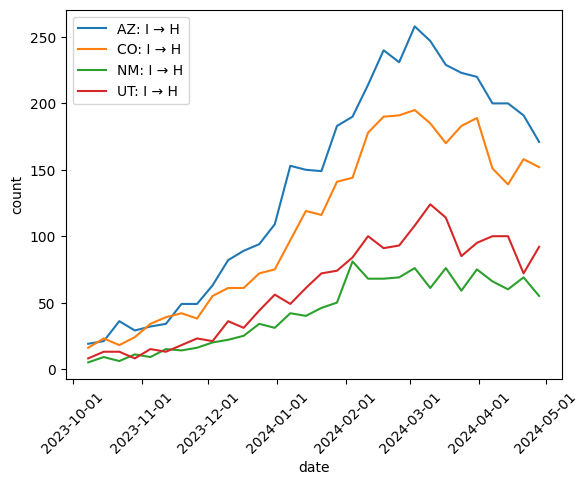

In [16]:
out.plot.line(geo=my_geo, time=my_time, quantity=my_quantity)

In [17]:
from epymorph.adrio.csv import CSVFileAxN
from epymorph.forecasting.likelihood import Poisson
from epymorph.forecasting.pipeline import ModelLink, Observations


my_observations = Observations(
    source=CSVFileAxN(
        file_path="temp.csv",
        dtype=np.int64,
        key_col=1,
        key_type="geoid",
        time_col=0,
        data_col=2,
        skiprows=1,
    ),
    model_link=ModelLink(
        geo=my_geo,
        time=my_time,
        quantity=my_quantity,
    ),
    likelihood=Poisson(),
)

In [21]:
from epymorph.forecasting.pipeline import FromRUME, ParticleFilterSimulator

my_rng = np.random.default_rng(seed=0)

pf_sim = ParticleFilterSimulator(
    config=FromRUME(rume=my_rume, num_realizations=100),
    observations=my_observations,
    save_trajectories=True,
)

pf_out = pf_sim.run(rng=my_rng)

Observation: 0, Label: 2023-10-08, Time Frame: 2023-10-08/2023-10-14 (7D)
Observation: 1, Label: 2023-10-15, Time Frame: 2023-10-15/2023-10-21 (7D)
Observation: 2, Label: 2023-10-22, Time Frame: 2023-10-22/2023-10-28 (7D)
Observation: 3, Label: 2023-10-29, Time Frame: 2023-10-29/2023-11-04 (7D)
Observation: 4, Label: 2023-11-05, Time Frame: 2023-11-05/2023-11-11 (7D)
Observation: 5, Label: 2023-11-12, Time Frame: 2023-11-12/2023-11-18 (7D)
Observation: 6, Label: 2023-11-19, Time Frame: 2023-11-19/2023-11-25 (7D)
Observation: 7, Label: 2023-11-26, Time Frame: 2023-11-26/2023-12-02 (7D)
Observation: 8, Label: 2023-12-03, Time Frame: 2023-12-03/2023-12-09 (7D)
Observation: 9, Label: 2023-12-10, Time Frame: 2023-12-10/2023-12-16 (7D)
Observation: 10, Label: 2023-12-17, Time Frame: 2023-12-17/2023-12-23 (7D)
Observation: 11, Label: 2023-12-24, Time Frame: 2023-12-24/2023-12-30 (7D)
Observation: 12, Label: 2023-12-31, Time Frame: 2023-12-31/2024-01-06 (7D)
Observation: 13, Label: 2024-01-07,

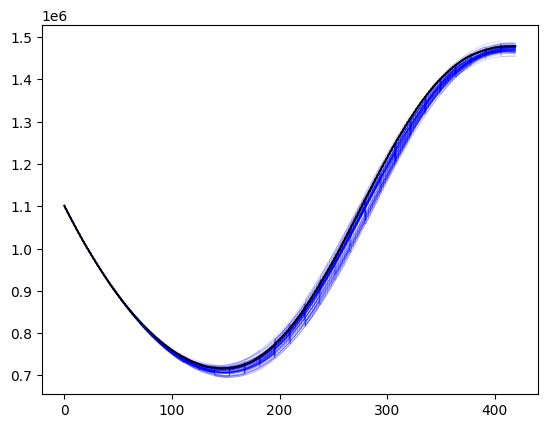

In [22]:
import matplotlib.pyplot as plt

compartment = 2
node = 0
plt.plot(pf_out.compartments[:, :, node, compartment].T, "b", linewidth=0.5, alpha=0.2)
plt.plot(out.compartments[:, node, compartment], "k")
plt.show()